## Fuzzy Portfolio Optimization
#### Implementation of "[A multi-period fuzzy portfolio optimization model with minimum transaction lots](http://www.sciencedirect.com/science/article/pii/S037722171400900X)" on Indian Stock Market

Dependencies
- deap 
- pandas
- numpy

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random
import operator

from finance import *

matplotlib.style.use('ggplot')

In [2]:
stock_indices = [
    'SBIN.NS',
    'HDFCBANK.NS',
    'ASIANPAINT.NS',
    'ACC.NS',
    'HCLTECH.NS',
    'YESBANK.NS',
    'KOTAKBANK.NS',
    'WIPRO.BO',
    'MARUTI.BO',
    'ITC.BO',
    'BPCL.BO',
    'BHARTIARTL.BO',
    'BHARATFIN.BO',
    'INFY.BO',
    'TCS.NS',
    'DABUR.NS',
    'EIHOTEL.NS',
    'BOSCHLTD.NS'
]
nstocks = len(stock_indices)
historical_data = get_stocks_data(stock_indices,filename="all_new", cache=True, start_date=datetime.datetime(2015,1,1), interval='w')
closing_price = historical_data['Close']
rate_of_return = get_rate_of_return(closing_price).interpolate()

In [3]:
t = 3
rf = 0.08*np.ones(t) # Yearly rate of return of risk free asset
transaction_cost_rate = 0.005 # Motilal Oswal Equity Delivery Charges
lot = lot_size = 100
init_wealth = 1000000
init_investment = np.zeros(nstocks)
max_lots = 50

In [4]:
max_risk = 0.10 # 10% weekly risk
min_return = 0.10 # 10% yearly return

In [5]:
et = 1 # Allowed weights entropy
k = 5

In [6]:
ror1 = rate_of_return.loc['2015-12-31':'2015-1-1']
ror2 = rate_of_return.loc['2016-12-31':'2016-1-1']
ror3 = rate_of_return.loc['2017-12-31':'2017-1-1']
p1 = closing_price.loc['2015-12-31':'2015-1-1'].iloc[0]
p2 = closing_price.loc['2016-12-31':'2016-1-1'].iloc[0]
p3 = closing_price.loc['2017-12-31':'2017-1-1'].iloc[0]
prices = pd.DataFrame([p1, p2, p3])
ror = [ror1, ror2, ror3]

In [7]:
def get_stats(rate_of_return):
    start = 0.01
    core_start_quan = 0.4
    core_end_quan = 0.7
    end = 0.95

    stats = rate_of_return.quantile([0, start, core_start_quan, core_end_quan, end,1])
    stats.loc['lSpread'] = stats.loc[core_start_quan] - stats.loc[start]
    stats.loc['rSpread'] = stats.loc[end] - stats.loc[core_end_quan]
    stats.loc['pmean'] = (stats.loc[core_start_quan]+stats.loc[core_end_quan])/2 + (stats.loc['rSpread']-stats.loc['lSpread'])/6
    stats.loc['pstd_e1'] = (-stats.loc[core_start_quan]+stats.loc[core_end_quan])/2 + (
        stats.loc['rSpread']+stats.loc['lSpread'])/6
    stats.loc['mean'] = rate_of_return.mean()
    stats.loc['std'] = rate_of_return.std()
    return stats

# Computing statstistics each time period
stats = [get_stats(r) for r in ror]
lot_prices = prices.values*lot_size

# Backup the data
_ = [s.to_excel('stats_%d.xls'%i) for i, s in enumerate(stats)]
prices.to_excel('stock_prices.xls')

$$\begin{alignat}{3}
&W_{T+1} & &=&& \sum_{i=1}^{n}{x_{t,i}p_{t,i}(1+r_{t,i})} + (W_T-\sum_{i=1}^{n}{x_{t,i}p_{t,i}}-C_t)(1+r_f(t)) \\
&where\;  & &W_T&& \text{ is Terminal wealth at end of time T} \\
& & &C_T&& \text{ is the total transaction cost at time T} 
\end{alignat}
$$

In [8]:
def total_cost_func(previous_investment, current_investment, current_price):
    transaction_amount = np.abs(previous_investment-current_investment)*current_price
    transaction_cost = transaction_amount.sum()*transaction_cost_rate
    total_cost = (current_investment*current_price).sum()+transaction_cost
    return total_cost, transaction_cost

def normalize_values(w):
    # Non negative constraint
    w[w<=0.] = .0
    
    # Integer Constraint
    w_frac, w_int = np.modf(w)
    w_factor = np.sign(w_frac)*np.random.randint(0, 2, w.shape)
    w[:] = w_int+w_factor
    
    # Cardinality constraint
    inv_ratios = (w*lot_prices)
    inv_ratios = inv_ratios/inv_ratios.sum(1).reshape(t, 1)
    for i, wi in enumerate(w):
        if np.sign(wi).sum()>k:
            w[i, np.argpartition(inv_ratios[i], nstocks-k)[:(nstocks-k)]]=0
    return w

In [9]:
w = np.random.randint(0, max_lots, [t, nstocks])
normalize_values(w)

# w = w / w.sum(1).reshape(t, 1) # Random initialization
# display(w)

array([[ 0,  0,  0,  0, 42,  0,  0,  0, 48,  0,  0,  0, 46,  5,  0, 29,  0,
         0],
       [ 0,  0,  0,  0, 47,  0,  0,  0, 36,  0,  0,  0, 34,  6,  0, 22,  0,
         0],
       [ 0, 30, 46,  0, 29,  0,  0,  0,  0, 37,  0,  0,  0, 25,  0,  0,  0,
         0]])

In [10]:
lot_prices = prices.values*lot_size
def evaluate(w):

    previous_investment = init_investment
    wealth = float(init_wealth)

    investment_ratio = np.zeros([t, nstocks+1])
    risk_free_investment = np.zeros(t)
    variance_risk = np.zeros(t)
    expected_terminal_wealth = np.zeros(t)
    actual_wealth = np.zeros(t)
    transaction_costs = np.zeros(t)
    
    total_var_risk = 0

    for i, (current_investment, current_price) in enumerate(zip(w, lot_prices)):
        total_cost, transaction_cost = total_cost_func(previous_investment, current_investment, current_price)
    
        # Budget Constraint
        while (wealth<total_cost):
#             print "Normalizing budget constraint"
            w[i] = current_investment = np.floor(current_investment/(total_cost/wealth)) #TODO Rectify this
            total_cost, transaction_cost = total_cost_func(previous_investment, current_investment, current_price)

        risk_free_investment[i] = wealth-total_cost
        investment_ratio[i][:nstocks] = current_price*current_investment/(wealth-transaction_cost)
        investment_ratio[i][nstocks] = risk_free_investment[i]/(wealth-transaction_cost)
    
        transaction_costs[i] = transaction_cost
        variance_risk[i] = total_var_risk = total_var_risk + ((investment_ratio[i][:nstocks]*
                                                              stats[i].loc['pstd_e1']).sum())**2 + ((investment_ratio[i]
                                                              [:nstocks]*stats[i].loc['lSpread']).sum()**2)/18.
        expected_terminal_wealth[i] = wealth = (current_price*current_investment*(1+52*stats[i].loc['pmean'].values)
                                               ).sum()+risk_free_investment[i]*(1+rf[i])
        actual_wealth[i] = awealth = (lot_prices[i+1]*current_investment
                                     ).sum()+risk_free_investment[i]*(1+rf[i]) if i!=t-1 else 0
        previous_investment = current_investment


    portfolio_mean_ror = (52*investment_ratio[:,:nstocks]*np.array([s.loc['pmean'].values for s in stats])).sum(1)+investment_ratio[:, nstocks]*rf
    actual_wealth = actual_wealth[:t-1
                                 ]
    budget_constraint = ((w*lot_prices).sum(1)+transaction_costs)-np.concatenate([[init_wealth], expected_terminal_wealth[:t-1]])
    min_mean_constraint = min_return-portfolio_mean_ror
    max_risk_constraint = np.sqrt(variance_risk)-max_risk
    entropy_constraint = et+(investment_ratio*np.log(investment_ratio+1e-40)).sum(1)
    cardinality_constraint = np.sign(w).sum(1)-k
    violent_values = np.concatenate([budget_constraint, min_mean_constraint, max_risk_constraint, 
                                     entropy_constraint, cardinality_constraint])
    
    
    return expected_terminal_wealth, transaction_costs, variance_risk, risk_free_investment, violent_values, actual_wealth, investment_ratio

expected_terminal_wealth, transaction_costs, variance_risk, risk_free_investment, violent_values, actual_wealth, investment_ratio = evaluate(w)

In [11]:
np.maximum(violent_values, 0)

array([ 0.  ,  0.  ,  0.  ,  0.02,  0.02,  0.02,  0.  ,  0.  ,  0.  ,
        1.  ,  1.  ,  1.  ,  0.  ,  0.  ,  0.  ])

In [12]:
def normalize_values_decorator(func):
    def wrapper(*args, **kargs):
        individual = func(*args, **kargs)
        for i in individual:
            normalize_values(i)
        return individual
    return wrapper

def generate_individual():
    w = np.random.randint(0, max_lots, [t, nstocks]).astype('float')
    normalize_values(w)
    return w

### Genetic Algorithm for non-linear mixed interger programming
- deap
- random

In [13]:
import random

from deap import base
from deap import creator
from deap import tools
from deap import algorithms


In [14]:
def cxLaplace(i1, i2, offset, scale):
    q = offset+scale*np.log(np.random.rand(t,nstocks))*np.sign(2*np.random.rand(t,nstocks)-1.)
    k = q*np.abs(i1-i2)
    i1[:] = i1 + k
    i2[:] = i2 + k
    return i1, i2

# TODO Restrict few bits
def muPower(individual, xl, xu, pl, pu, indpb=0.1):
    sl = (np.random.rand(*(individual.shape))<indpb)*np.random.rand(*(individual.shape))**(1./pl)
    su = (np.random.rand(*(individual.shape))<indpb)*np.random.rand(*(individual.shape))**(1./pu)
    t = (individual-xl)/(xu-xl+1e-20)
    r = np.random.rand(*(individual.shape))
    individual[:] = np.where(r<t, individual-sl*(individual-xl), individual+su*(xu-individual))
    return individual,
# def muPower(individual, xl, xu, pl, pu, indpb=0.1):
#     for num in np.nditer(individual, op_flags=['readwrite']):
#         if np.random.rand()<=indpb:
#             t = (num-xl)/(xu-xl+1e-20)
#             r = np.random.rand()
#             s = -(num-xl)*np.random.rand()**(1./pl) if r<t else (xu-num)*np.random.rand()**(1./pu)
# #             num[...] = np.where(r<t, num-s*(num-xl), num+s*(xu-num))
#             num[...] = num+s
#     return individual,

In [15]:

def evaluate_terminal_wealth(ind):
    res = evaluate(ind)
    return res[0][t-1], np.maximum(res[4],0).sum()

def evaluate_total_risk(ind):
    res = evaluate(ind)
    return res[2][t-1], np.maximum(res[4],0).sum()

def eval(w, obj_func):
    global f_worst
    main_objective, violent_values = obj_func(w)
    if np.abs(violent_values.sum())<1e-10:
        f_worst = worst_check_operator(f_worst, main_objective) if f_worst is not init_worst else main_objective
        return main_objective,
    else:
        return mixing_operator(f_worst, violent_values.sum()),


In [16]:
def create_toolbox(eval_fn, is_min=True, offset=0., scale=0.25, pl=0.35, pu=0.25, indpb=0.10, **kwargs):
    
    if not isinstance(is_min, tuple):
        is_min = (-1.0, ) if is_min else (1.0, )
    creator.create("Fitness", base.Fitness, weights=is_min)
    creator.create("Individual", np.ndarray, fitness=creator.Fitness)

    toolbox = base.Toolbox()
    # toolbox.register("init_random", np.random.randint, 0, max_lots, [t, nstocks])
    # toolbox.register("init_individual", tools.initIterate, normalize_values, toolbox.init_random)
    toolbox.register("individual", tools.initIterate, creator.Individual, generate_individual)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("mate", cxLaplace, offset=offset, scale=scale)
    toolbox.decorate("mate", normalize_values_decorator)

    toolbox.register("mutate", muPower, xl=0, xu=max_lots, pl=pl, pu=pu, indpb=indpb)
    toolbox.decorate("mutate", normalize_values_decorator)

    toolbox.register("select", tools.selTournament, tournsize=3)
    # toolbox.register("evaluate", eval, obj_func=evaluate_total_risk)
    toolbox.register('eval_fn', eval_fn, **kwargs)
    toolbox.register("evaluate", eval, obj_func=toolbox.eval_fn)
    return toolbox


In [17]:
# f_worst = init_worst
# goptimum = init_worst

def global_optimum(indvs):
    global goptimum, optimum_check_operator
    goptimum = optimum_check_operator(goptimum, optimum_np_operator(indvs))
    return goptimum

def count_non_feasible(indvs):
    global f_worst
    return feasible_check(indvs, f_worst).sum()

def start_ga(toolbox, cxpb, mutpb, n=200, ngen=200, hof=None, ga_stats=None):
    global f_worst, goptimum, is_min
    f_worst = init_worst
    goptimum = init_worst

    pop = toolbox.population(n=n)
    hof = tools.HallOfFame(10, similar=np.array_equal) if hof is None else hof
    if ga_stats is not False:
        ga_stats = tools.Statistics(lambda ind: ind.fitness.values)
        ga_stats.register("avg", np.mean)
        ga_stats.register("std", np.std)
        if is_min:
            ga_stats.register("max", np.max)
            ga_stats.register("min", np.min)
        else:
            ga_stats.register("min", np.min)
            ga_stats.register("max", np.max)
        ga_stats.register("goptimum", global_optimum)
        ga_stats.register("ninfeasible", count_non_feasible)
    else: ga_stats = None

    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=cxpb, mutpb=mutpb, ngen=ngen, 
                                   stats=ga_stats, halloffame=hof, verbose=True)
    return hof, log

def set_environment(is_min):
    global init_worst, mixing_operator, worst_check_operator
    global optimum_check_operator, optimum_np_operator, feasible_check
    if isinstance(is_min, tuple):
        init_worst = -1e10*is_min
    else: init_worst = 1e10 if is_min else -1e10
    mixing_operator = operator.add if is_min else operator.sub
    worst_check_operator = max if is_min else min
    optimum_check_operator = min if is_min else max
    optimum_np_operator = np.min if is_min else np.max
    feasible_check = np.greater if is_min else np.less


In [ ]:
is_min = True
set_environment(is_min)
toolbox = create_toolbox(evaluate_total_risk, is_min=is_min, pl=.2, pu=.2, indpb=0.05)
hof, log = start_ga(toolbox, n=200, ngen=500, cxpb=0.8, mutpb=0.2)
best_risk = hof[0]

In [19]:
best_risk = hof[0]

In [ ]:
is_min = False
set_environment(is_min)
toolbox = create_toolbox(evaluate_terminal_wealth, is_min=is_min, pl=0.35, pu=0.25, indpb=0.05)
hof, log = start_ga(toolbox, ngen=500, cxpb=0.8, mutpb=0.2)
best_wealth = hof[0]

In [21]:
e_min, e_max = evaluate_terminal_wealth(best_risk)[0], best_wealth.fitness.values[0]

In [22]:
v_min, v_max = np.sqrt(best_risk.fitness.values[0]), np.sqrt(evaluate_total_risk(best_wealth)[0])

In [23]:
e_min, e_max, v_min, v_max 

(1499343.9014776065,
 3202094.4850515923,
 0.014714626848098492,
 0.068004953293388348)

In [29]:
e_mid = 2.5e6
v_mid = 0.04
theta_e = 50
theta_v = 50

In [30]:
def wealth_satisfaction(w, theta_e, theta_v):
    res = evaluate(w)
    wealth = res[0][t-1]
    risk = np.sqrt(res[2][t-1])
    violent_values = np.maximum(res[4],0).sum()
    wealth = (wealth-e_mid)/(e_max-e_min)
    wealth = 1/(1+np.exp(-theta_e*wealth))
    wealth = min(max(wealth, 0), 1)

    risk = (risk-v_mid)/(v_min-v_max)
    risk = 1/(1+np.exp(-theta_v*risk))
    risk = min(max(risk, 0), 1)
    
    return min(risk, wealth), violent_values#, wealth, risk
    
    #     return res[0][t-1], np.maximum(res[4],0).sum()
    #     return res[2].sum(), np.maximum(res[4],0).sum()


In [31]:
print wealth_satisfaction(best_risk, theta_e, theta_v)
print wealth_satisfaction(best_wealth, theta_e, theta_v)

(1.7334033637470659e-13, 0.0)
(3.8774942000899735e-12, 0.0)


In [32]:
def eval_fuzzy(theta_e, theta_v):
    is_min = False
    set_environment(is_min)
    toolbox = create_toolbox(wealth_satisfaction, is_min=is_min, pl=0.3, pu=0.2, indpb=0.05, theta_e=theta_e, theta_v=theta_v)
    hof, log = start_ga(toolbox, ngen=1000, cxpb=0.8, mutpb=0.2)
    return hof, log


In [ ]:
hof_exp, _  = eval_fuzzy(theta_e=10, theta_v=80)
hof_var, _  = eval_fuzzy(theta_e=80, theta_v=10)
hof_average, _  = eval_fuzzy(theta_e=40, theta_v=40)


In [35]:
def eval_wealth_risk(w):
    res = evaluate(w)
    wealth = res[0][t-1]
    risk = np.sqrt(res[2][t-1])
    violent_value = np.maximum(res[4],0).sum()
    if violent_value<1e-12:
        return wealth, risk
    else:
        return -1e10-violent_value, 1e10+violent_value
    


### Saving the solutions

In [36]:
def save_summary(w, filename = 'file.xls'):

    res = evaluate(w)
    df = pd.DataFrame(w, index=prices.index, columns=prices.columns)
    df.to_excel('nlots_%s'%filename)
    df = lot_size*df*prices
    df['RiskFree'] = res[3]
    df.loc['weights_0'] = res[6][0]
    df.loc['weights_1'] = res[6][1]
    df.loc['weights_2'] = res[6][2]
    df['TerminalWealth'] = np.concatenate([res[0], res[0]])
    df['TransactionCost'] = np.concatenate([res[1], res[1]])
    df['Risk'] = np.concatenate([res[2], res[2]])
    df['InitialWealth'] = df.sum(1) - df['TerminalWealth'] - df['Risk']
    df.loc['staisfaction'] = wealth_satisfaction(w, theta_e, theta_v)[0]
    df.loc['risk'] = np.sqrt(res[2].sum())
    df.to_excel(filename)
#     print zip(res[5], res[0], res[])
    return res, df

_ = save_summary(best_risk, 'min_risk_sol.xls')
_ = save_summary(best_wealth, 'max_wealth_sol.xls')

In [37]:
theta_e, theta_v = 40, 40
_ = save_summary(hof_average[0], 'best_40_40.xls')
theta_e, theta_v = 10, 80
_ = save_summary(hof_exp[0], 'best_10_80.xls')
theta_e, theta_v = 80, 10
_ = save_summary(hof_var[0], 'best_80_10.xls')

### Generating Pareto Front for the problem

In [38]:
hof = tools.ParetoFront(np.array_equal)

In [ ]:
is_min = False
set_environment(is_min)
toolbox = create_toolbox(eval_wealth_risk, is_min=(1., -1.), pl=0.3, pu=0.2, indpb=0.05)
toolbox.register("select", tools.selNSGA2)
toolbox.register("evaluate", eval_wealth_risk)
ga_stats = tools.Statistics(lambda ind: ind.fitness.values)
ga_stats.register("avg", np.mean, axis=0 )

ga_stats.register("max", np.max, axis=0)
ga_stats.register("min", np.min, axis=0)
ga_stats.register("npoints", lambda x: len(hof))
np.set_printoptions(precision=3)
for i in range(10):
    pop = toolbox.population(n=200)
    pop, log = algorithms.eaMuPlusLambda(pop, toolbox, mu=200, lambda_=200, ngen=500, cxpb=0.8, mutpb=0.2, halloffame=hof, stats=ga_stats)
# hof, log = start_ga(toolbox, n=200, ngen=300, cxpb=0.8, mutpb=0.2, hof=hof, ga_stats=None)

In [40]:
terminal_wealth = [x.fitness.values[0] for x in hof.items]
risk = [x.fitness.values[1] for x in hof.items]

In [41]:
df = pd.DataFrame([(tt,r) for tt,r in zip(terminal_wealth, risk)], columns=['TerminalWealth', 'Risk'])

In [ ]:
df.to_excel('optimal_frontier.xls')

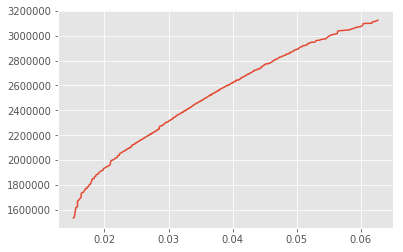

In [43]:
plt.plot(risk, terminal_wealth)
plt.show()

In [ ]:
start = 0.01
core_start_quan = 0.4
core_end_quan = 0.7
end = 0.95

In [ ]:
index_id = 'HDFCBANK.NS'
index = stats[0][index_id]
plt.hist(rate_of_return[index_id], 20, normed=0)
plt.plot([index.loc[start],index.loc[core_start_quan], index.loc[core_end_quan], index.loc[end]], [0,20,20,0], 'b')
plt.show() # display(rate_of_return['MARUTI.BO']*100)